In [5]:
import base64
#import cStringIO
import sys
import tempfile

MODEL_BASE = '/Users/aadebuger/GEXT/github2019/models/research'
sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')


import numpy as np
from PIL import Image
from PIL import ImageDraw
import tensorflow as tf
from utils import label_map_util




PATH_TO_CKPT = '/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

content_types = {'jpg': 'image/jpeg',
                 'jpeg': 'image/jpeg',
                 'png': 'image/png'}
extensions = sorted(content_types.keys())


def is_image():
  def _is_image(form, field):
    if not field.data:
      raise ValidationError()
    elif field.data.filename.split('.')[-1].lower() not in extensions:
      raise ValidationError()

  return _is_image





class ObjectDetector(object):

  def __init__(self):
    self.detection_graph = self._build_graph()
    self.sess = tf.Session(graph=self.detection_graph)

    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    self.category_index = label_map_util.create_category_index(categories)

  def _build_graph(self):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    return detection_graph

  def _load_image_into_numpy_array(self, image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

  def detect(self, image):
    image_np = self._load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = self.detection_graph
    image_tensor = graph.get_tensor_by_name('image_tensor:0')
    boxes = graph.get_tensor_by_name('detection_boxes:0')
    scores = graph.get_tensor_by_name('detection_scores:0')
    classes = graph.get_tensor_by_name('detection_classes:0')
    num_detections = graph.get_tensor_by_name('num_detections:0')

    (boxes, scores, classes, num_detections) = self.sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    boxes, scores, classes, num_detections = map(
        np.squeeze, [boxes, scores, classes, num_detections])

    return boxes, scores, classes.astype(int), num_detections


def draw_bounding_box_on_image(image, box, color='red', thickness=4):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  ymin, xmin, ymax, xmax = box
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)

from io import BytesIO
def encode_image(image):
  image_buffer = BytesIO()
  image.save(image_buffer, format='PNG')
  imagevalue = image_buffer.getvalue()
  base64str=base64.b64encode(imagevalue).decode()

  imgstr = 'data:image/png;base64,{:s}'.format(
     base64str )
  return imgstr


def detect_objects(image_path):
  image = Image.open(image_path).convert('RGB')
  boxes, scores, classes, num_detections = client.detect(image)
  image.thumbnail((480, 480), Image.ANTIALIAS)
  print(num_detections)
  new_images = {}
  for i in range(int(num_detections)):
    print("scres[i",scores[i])
    if scores[i] < 0.35: continue
    cls = classes[i]
    if cls not in new_images.keys():
      new_images[cls] = image.copy()
    print("boxes",boxes[i])
    draw_bounding_box_on_image(new_images[cls], boxes[i],
                               thickness=int(scores[i]*10)-4)

  result = {}
#  result['original'] = encode_image(image.copy())
  print(new_images)
  count = 0 
  for cls, new_image in new_images.items():
    category = client.category_index[cls]['name']
    print(category)
    result[category] = encode_image(new_image)
    new_image.save("{0}.jpg".format(count))
    count=count+1

  return result



PATH_TO_CKPT='/Users/aadebuger/GEXT/model/ssd_mobilenet_v1_0.75_depth_300x300_coco14_sync_2018_07_03/frozen_inference_graph.pb'

client = ObjectDetector()

1.0
scres[i 0.4265248
boxes [0.5007487  0.6364706  0.81645745 0.87388664]
{84: <PIL.Image.Image image mode=RGB size=480x360 at 0x1278FCEF0>}
book
1



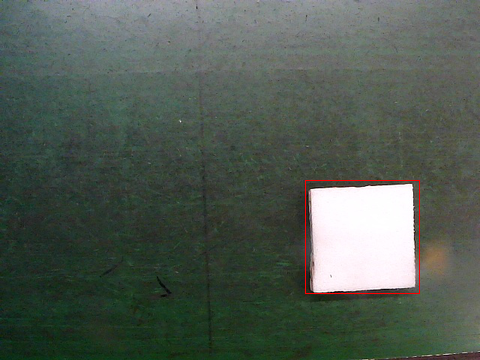

In [6]:
result=detect_objects('/Users/aadebuger/GEXT/aixgf/tzimagedata/dqn/object20190505121605.jpg')
print(len(result))
from IPython.display import HTML
HTML("<img src='{0}'/>".format(result['book']))